In [341]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
import NSMap as ns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [342]:
filename = "../datasets/birddata_cleaned.csv"

df_raw = pd.read_csv(filename, encoding="utf-8", na_filter=True)

# filter out time series with any NAs or which are sums of NAs
df = df_raw[["Year","Common murre Total", "Brandt's cormorant Total"]]
table = df.to_numpy(dtype=np.float64)

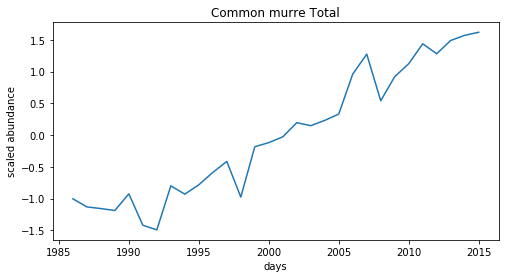

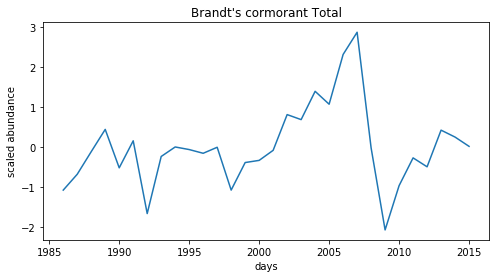

In [343]:
for i, series in enumerate(table.T[1:]):
    fig, ax = plt.subplots(1,figsize=(8,4))
    ax.set_title(df.columns[i+1])
    ax.plot(table[:,0], ns.standardize(np.sqrt(series)))
    ax.set_ylabel("scaled abundance")
    ax.set_xlabel("days")
    plt.show()

In [344]:
E_max = 4
taus = np.arange(1,5)
r_sqrd_table = np.zeros((len(taus), 2))

In [345]:
"""
for i, series in enumerate(table.T[1:]):
    series = ns.standardize(np.sqrt(series))
    r_sqrds = [ns.get_delta_agg(series, E_max, tau=tau,
                             return_forecast_skill=True)[2] 
                   for tau in taus]
    r_sqrd_table[:,i] = r_sqrds
    
np.savetxt("../results/seabird_analysis/seabird_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")
"""

'\nfor i, series in enumerate(table.T[1:]):\n    series = ns.standardize(np.sqrt(series))\n    r_sqrds = [ns.get_delta_agg(series, E_max, tau=tau,\n                             return_forecast_skill=True)[2] \n                   for tau in taus]\n    r_sqrd_table[:,i] = r_sqrds\n    \nnp.savetxt("../results/seabird_analysis/seabird_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")\n'

In [346]:
# Check Autocorrelation

autocorr_table = np.zeros((len(taus),2))

for i, series in enumerate(table.T[1:]):
    series = ns.standardize(np.sqrt(series))
    autocorr_table[:,i] = np.array([np.corrcoef(series[tau:],
                                                series[:-tau])[0,1]
                                  for tau in taus])

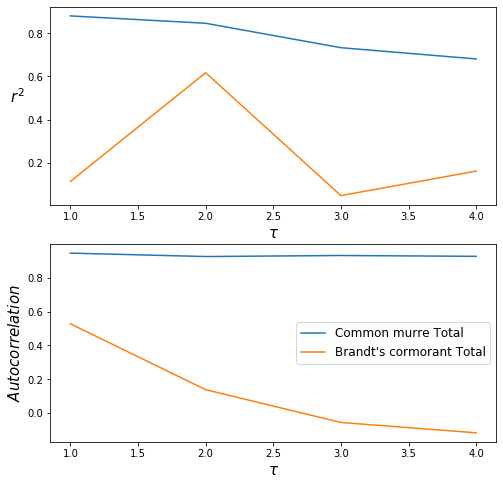

In [347]:
r_sqrd_table = np.loadtxt("../results/seabird_analysis/seabird_rsqrd_vs_tau.csv", delimiter=",")

fig, ax = plt.subplots(2,figsize=(8,8))
for i in range(2):
    ax[0].plot(taus, r_sqrd_table[:,i], label=df.columns[i+1])
    
for i in range(2):
    ax[1].plot(taus, autocorr_table[:,i], label=df.columns[i+1])

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend(fontsize = 12)

In [348]:
# For the Common murre, we choose tau = 1 as there is no  appreciable drop
# in autocorrelation by increasing it.
# For the Brandt's cormorant, we choose tau = 2 since the autocorrelation drops
# to around 0.2 but the forecast skill jumps up to 0.6

In [349]:
t = table.T[0,:].copy()
t = (t - np.min(t)) / np.ptp(t)

common_murre_series = ns.standardize(np.sqrt(table.T[1,:]))
common_murre_tau = 1
common_murre_E = 4

brandt_cormorant_series = ns.standardize(np.sqrt(table.T[2,:]))
brandt_cormorant_tau = 2
brandt_cormorant_E = 2

In [350]:
delta_agg_murr, theta_agg_murr, r_sqrd_murr = ns.get_delta_agg(common_murre_series, common_murre_E, tau = common_murre_tau, t = t, return_forecast_skill=True)

In [351]:
delta_agg_corm, theta_agg_corm, r_sqrd_corm = ns.get_delta_agg(brandt_cormorant_series, brandt_cormorant_E, tau = brandt_cormorant_tau, t = t, return_forecast_skill=True)

In [352]:
print("Common Murre")
print(f"aggregated delta = {delta_agg_murr:0.3f}, r_sqrd = {r_sqrd_murr:0.3f}")

print("Brandt Cormorant")
print(f"aggregated delta = {delta_agg_corm:0.3f}, r_sqrd = {r_sqrd_corm:0.3f}")

Common Murre
aggregated delta = 0.000, r_sqrd = 0.880
Brandt Cormorant
aggregated delta = 0.000, r_sqrd = 0.431


Multiwindow Analysis for Common Murre

In [353]:
year_steps = 1
maxLen = common_murre_series.shape[0]
lengths = np.arange(year_steps*10,maxLen+1,step=year_steps)

In [354]:
# length, starting index, delta, theta, r_sqrd
"""
n_rows = 231
results = np.zeros((n_rows, 5))
tally = 0

for length in lengths:
    for start in np.arange(0, maxLen - length+1, step=year_steps):
        ts_chunk = common_murre_series[start:length+start]
        
        delta, theta, r_sqrd = ns.get_delta_agg(ts_chunk, common_murre_E, tau = common_murre_tau, 
                                             return_forecast_skill = True)
        results[tally] = np.array([length, start, delta, theta, r_sqrd])
        
        tally += 1
np.savetxt(f"../results/seabird_analysis/common_murre_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")
"""

'\nn_rows = 231\nresults = np.zeros((n_rows, 5))\ntally = 0\n\nfor length in lengths:\n    for start in np.arange(0, maxLen - length+1, step=year_steps):\n        ts_chunk = common_murre_series[start:length+start]\n        \n        delta, theta, r_sqrd = ns.get_delta_agg(ts_chunk, common_murre_E, tau = common_murre_tau, \n                                             return_forecast_skill = True)\n        results[tally] = np.array([length, start, delta, theta, r_sqrd])\n        \n        tally += 1\nnp.savetxt(f"../results/seabird_analysis/common_murre_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")\n'

In [361]:
# Convert the delta values for each subseries into a square matrix
# which is plotted using matplotlib's imshow.
def makeHeatMapSeabird(results):
    nonstationarityHeatMap = np.zeros((21,21)) * np.nan
    for l, o, d, t, r in results:
        i_length = 28-(int(l / year_steps) - 2)
        i_offset = int(o / year_steps)
        
        nonstationarityHeatMap[i_length, i_offset] = d
        
    return nonstationarityHeatMap

In [367]:
# Make the figure
def makeFigureSeabird(nonstationarityHeatMap, ts, name, ax):
    name_to_fig_title = {"Brandt's Cormorant": "Figure_S15"}
    
    scaling = lengths[-1]
    
    # im = ax.imshow(np.zeros(nonstationarityHeatMap[:-2].shape), cmap=cm.Greys)
    im = ax.imshow(np.log(nonstationarityHeatMap+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(40, step=4))
    ax.set_yticks(np.arange(21, step=5))
    ax.set_xticklabels([])
    ax.set_yticklabels(np.flip(lengths[::5]))
    ax.set_ylim(21,-1)
    ax.set_xlim(-1.5,30.5)
    
    ax.set_ylabel("Time series length (years)",fontsize=15)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(table[:,0], ts,c="dodgerblue")
    axTS.set_ylabel(name,fontsize=12)
    axTS.set_xlabel("Start year",fontsize=15)
    axTS.set_xticks(table[::4,0])
    axTS.set_yticks([])
    
    plt.savefig(f"../figures_eps/seabird_multiwindow/{name_to_fig_title[name]}.eps", format="eps", bbox_inches="tight", transparent=False, facecolor="white")
    plt.show()

In [368]:
# Make a custom orange to blue color scheme
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba]) 
custom_cmap.set_bad("white", 1)

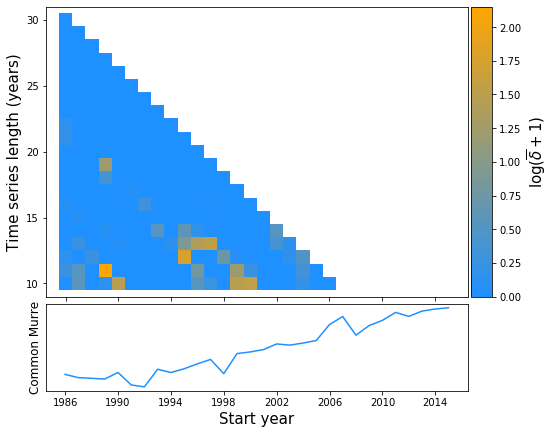

In [364]:
fig, ax = plt.subplots(1, figsize = (8,8))

results = np.loadtxt(f"../results/seabird_analysis/common_murre_time_window.csv",
                         delimiter=",")

nonstationarityHeatMap = makeHeatMapSeabird(results)
makeFigureSeabird(nonstationarityHeatMap, common_murre_series, "Common Murre", ax)

Multiwindow Analysis for Brandt Cormorant

In [365]:
# length, starting index, delta, theta, r_sqrd
"""
n_rows = 231
results = np.zeros((n_rows, 5))
tally = 0

for length in lengths:
    for start in np.arange(0, maxLen - length+1, step=year_steps):
        ts_chunk = brandt_cormorant_series[start:length+start]
        
        delta, theta, r_sqrd = ns.get_delta_agg(ts_chunk, brandt_cormorant_E, tau = brandt_cormorant_tau, 
                                             return_forecast_skill = True)
        results[tally] = np.array([length, start, delta, theta, r_sqrd])
        
        tally += 1
np.savetxt(f"../results/seabird_analysis/brandt_cormorant_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")
"""

'\nn_rows = 231\nresults = np.zeros((n_rows, 5))\ntally = 0\n\nfor length in lengths:\n    for start in np.arange(0, maxLen - length+1, step=year_steps):\n        ts_chunk = brandt_cormorant_series[start:length+start]\n        \n        delta, theta, r_sqrd = ns.get_delta_agg(ts_chunk, brandt_cormorant_E, tau = brandt_cormorant_tau, \n                                             return_forecast_skill = True)\n        results[tally] = np.array([length, start, delta, theta, r_sqrd])\n        \n        tally += 1\nnp.savetxt(f"../results/seabird_analysis/brandt_cormorant_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")\n'

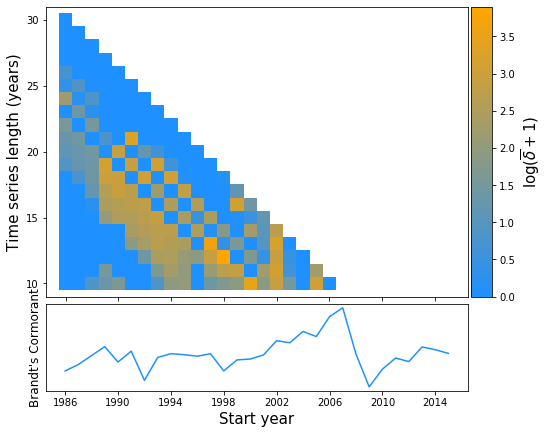

In [369]:
results = np.loadtxt(f"../results/seabird_analysis/brandt_cormorant_time_window.csv",
                         delimiter=",")

fig, ax = plt.subplots(1, figsize = (8,8))

nonstationarityHeatMap = makeHeatMapSeabird(results)
makeFigureSeabird(nonstationarityHeatMap, brandt_cormorant_series, "Brandt's Cormorant", ax)